# 🧠 Robot Navigation Neural Network Training
===========================================

**Step-by-step training and visualization of the goal-aware robot navigation neural network.**

## Features:
- ✅ **Goal-aware navigation** (11 features: 9 perception + 2 goal_delta) 🎯
- ✅ **Basic navigation** (9 features: perception only)
- ✅ **Wall padding** (12×12 environments with 1-cell borders)
- ✅ **Compass-like navigation** (goal direction awareness)
- ✅ **Flexible configuration**
- ✅ **Interactive visualization**

## Quick Start:
1. Edit configuration in Cell 1
2. Run cells sequentially
3. Visualize training progress
4. Analyze goal-aware vs basic performance


In [6]:
# 🎯 CONFIGURATION
# ================
USE_GOAL_AWARE = True    # True=goal-aware (11 features), False=basic (9 features)

# 📦 IMPORTS
# ==========
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Add project to path
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Force reload modules to get latest changes
if 'core.pytorch_network' in sys.modules:
    del sys.modules['core.pytorch_network']
if 'scripts.train_nn' in sys.modules:
    del sys.modules['scripts.train_nn']

# Import training utilities
from scripts.train_nn import (
    load_data, prepare_data_loaders, create_model, create_trainer,
    get_predictions, calculate_metrics
)
from core.pytorch_network import load_config

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Setup complete!")
print(f"\n🎯 CONFIGURATION")
print("=" * 50)
print(f"   Mode: {'Goal-Aware 🎯' if USE_GOAL_AWARE else 'Basic'}")
print(f"   Features: {'11 (9 perception + 2 goal_delta)' if USE_GOAL_AWARE else '9 (perception only)'}")
print(f"   Architecture: {'11 → 64 → 32 → 4' if USE_GOAL_AWARE else '9 → 64 → 32 → 4'}")
print(f"   Expected Accuracy: {'80-85%' if USE_GOAL_AWARE else '70-75%'}")

# Test the load_config function
print(f"\n🧪 Testing load_config function:")
try:
    test_config = load_config(goal_aware=USE_GOAL_AWARE)
    print(f"   ✅ load_config(goal_aware={USE_GOAL_AWARE}) works!")
    print(f"   Input size: {test_config['model']['input_size']}")
except Exception as e:
    print(f"   ❌ Error: {e}")


✅ Setup complete!

🎯 CONFIGURATION
   Mode: Goal-Aware 🎯
   Features: 11 (9 perception + 2 goal_delta)
   Architecture: 11 → 64 → 32 → 4
   Expected Accuracy: 80-85%

🧪 Testing load_config function:
✅ Configuration loaded from /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/configs/nn_config.yaml
🎯 Updated config for Goal-Aware Mode (11 features)
   ✅ load_config(goal_aware=True) works!
   Input size: 11


In [7]:
# 📊 LOAD DATA
# ============
config = load_config(goal_aware=USE_GOAL_AWARE)
X, y, metadata, is_goal_aware = load_data(USE_GOAL_AWARE)
train_loader, val_loader, test_loader = prepare_data_loaders(X, y, config)

# Display sample data
print(f"\n📋 Sample Data:")
print(f"   Input shape: {X[0].shape}")
print(f"   Sample features: {X[0][:10]}...")
print(f"   Sample label: {y[0]}")

# Show goal delta if in goal-aware mode
if USE_GOAL_AWARE and X.shape[1] == 11:
    goal_delta = X[0][9:11]
    print(f"   Goal delta: ({goal_delta[0]:.0f}, {goal_delta[1]:.0f})")
    print(f"   Direction: {'UP' if goal_delta[0] < 0 else 'DOWN'} {'LEFT' if goal_delta[1] < 0 else 'RIGHT'}")
    print(f"   Distance: {abs(goal_delta[0]) + abs(goal_delta[1])} steps")


✅ Configuration loaded from /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/configs/nn_config.yaml
🎯 Updated config for Goal-Aware Mode (11 features)
📂 Loading data: large_training_dataset.npz
📂 Training data loaded from /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/data/raw/large_training_dataset.npz
✅ Data loaded: 8761 samples
   Features: 11 (Goal-Aware 🎯)
   Environments: 1000
📊 Data splits:
   Train: 7007 samples
   Validation: 877 samples
   Test: 877 samples

📋 Sample Data:
   Input shape: (11,)
   Sample features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 4.]...
   Sample label: 1
   Goal delta: (4, -1)
   Direction: DOWN LEFT
   Distance: 5.0 steps


In [8]:
# 🧠 CREATE MODEL
# ===============
model = create_model(config)
trainer = create_trainer(model, config)

print(f"\n📝 Training Configuration:")
print(f"   Epochs: {config['training']['epochs']}")
print(f"   Batch size: {config['training']['batch_size']}")
print(f"   Early stopping: {config['training']['early_stopping']['patience']} epochs")



📝 Training Configuration:
   Epochs: 200
   Batch size: 64
   Early stopping: 55 epochs


In [9]:
# 🔥 TRAIN MODEL
# ==============
print(f"🚀 Starting training...")
print("=" * 60)

history = trainer.train(
    train_loader,
    val_loader,
    epochs=config['training']['epochs'],
    early_stopping_patience=config['training']['early_stopping']['patience'],
    verbose=True
)

print(f"\n✅ Training completed!")
print(f"   Epochs trained: {len(history['train_losses'])}")
print(f"   Best validation accuracy: {max(history['val_accuracies']):.4f}")


🚀 Starting training...
🚀 Starting training on cpu
🧠 Architecture: 11 → 64 → 32 → 4
⚙️  Learning rate: 0.0005
🛡️  Dropout rate: 0.2
------------------------------------------------------------
Epoch   0: Train Loss=1.2944, Train Acc=46.77%, Val Loss=1.1637, Val Acc=68.76%
Epoch  10: Train Loss=0.9420, Train Acc=81.12%, Val Loss=0.9067, Val Acc=84.38%
Epoch  20: Train Loss=0.9001, Train Acc=85.16%, Val Loss=0.8812, Val Acc=87.00%
Epoch  30: Train Loss=0.8816, Train Acc=86.88%, Val Loss=0.8719, Val Acc=87.34%
Epoch  40: Train Loss=0.8713, Train Acc=87.71%, Val Loss=0.8697, Val Acc=87.34%
Epoch  50: Train Loss=0.8674, Train Acc=87.93%, Val Loss=0.8620, Val Acc=88.26%
Epoch  60: Train Loss=0.8647, Train Acc=88.15%, Val Loss=0.8643, Val Acc=88.03%
Epoch  70: Train Loss=0.8582, Train Acc=88.81%, Val Loss=0.8632, Val Acc=87.69%
Epoch  80: Train Loss=0.8568, Train Acc=88.91%, Val Loss=0.8656, Val Acc=87.34%
Epoch  90: Train Loss=0.8565, Train Acc=88.88%, Val Loss=0.8605, Val Acc=88.03%
Epoch 10

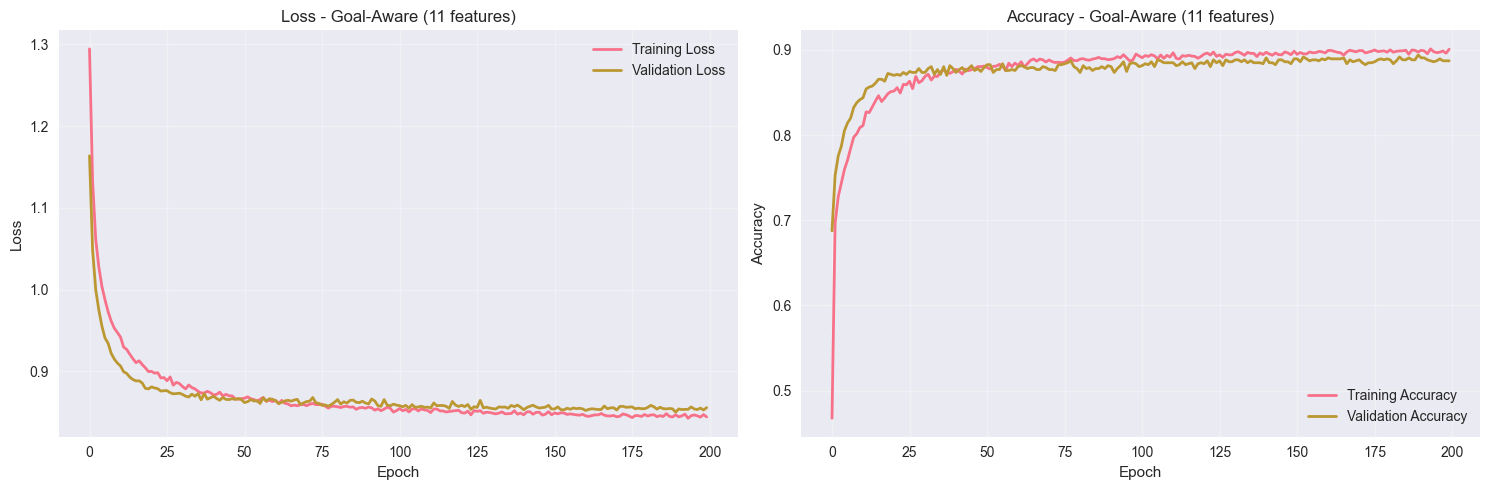


📊 Training Analysis:
   Training Accuracy: 0.9007 (90.1%)
   Validation Accuracy: 0.8871 (88.7%)
   Overfitting Gap: 0.0136 (1.4%)
✅ Excellent: No overfitting

🎯 Performance vs Expected:
   Expected Accuracy: 80%
   Actual Accuracy: 88.7%
   Difference: +0.1%


In [10]:
# 📈 VISUALIZE TRAINING HISTORY
# =============================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

mode_name = "Goal-Aware" if USE_GOAL_AWARE else "Basic"
feature_desc = "11 features" if USE_GOAL_AWARE else "9 features"

# Loss plot
axes[0].plot(history['train_losses'], label='Training Loss', linewidth=2)
axes[0].plot(history['val_losses'], label='Validation Loss', linewidth=2)
axes[0].set_title(f'Loss - {mode_name} ({feature_desc})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_accuracies'], label='Training Accuracy', linewidth=2)
axes[1].plot(history['val_accuracies'], label='Validation Accuracy', linewidth=2)
axes[1].set_title(f'Accuracy - {mode_name} ({feature_desc})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print analysis
final_train_acc = history['train_accuracies'][-1]
final_val_acc = history['val_accuracies'][-1]
overfitting = final_train_acc - final_val_acc

print(f"\n📊 Training Analysis:")
print(f"   Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
print(f"   Overfitting Gap: {overfitting:.4f} ({overfitting*100:.1f}%)")

if overfitting > 0.1:
    print(f"⚠️  Warning: Significant overfitting")
elif overfitting > 0.05:
    print(f"✅ Acceptable: Minimal overfitting")
else:
    print(f"✅ Excellent: No overfitting")

# Performance comparison
expected_acc = 0.80 if USE_GOAL_AWARE else 0.70
performance_vs_expected = final_val_acc - expected_acc
print(f"\n🎯 Performance vs Expected:")
print(f"   Expected Accuracy: {expected_acc*100:.0f}%")
print(f"   Actual Accuracy: {final_val_acc*100:.1f}%")
print(f"   Difference: {performance_vs_expected:+.1f}%")


In [11]:
# 🎯 TEST SET EVALUATION
# ======================
test_accuracy, test_loss = trainer.evaluate(test_loader)

print(f"📊 Test Set Performance:")
print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"   Loss: {test_loss:.4f}")

# Get predictions for detailed analysis
predictions, targets = get_predictions(model, test_loader, trainer.device)
metrics = calculate_metrics(predictions, targets)

print(f"\n📋 Detailed Metrics:")
print(f"   Precision: {metrics['precision']:.4f}")
print(f"   Recall: {metrics['recall']:.4f}")
print(f"   F1-Score: {metrics['f1']:.4f}")


📊 Test Set Performance:
   Accuracy: 0.8383 (83.8%)
   Loss: 0.9076

📋 Detailed Metrics:
   Precision: 0.9112
   Recall: 0.9074
   F1-Score: 0.9082


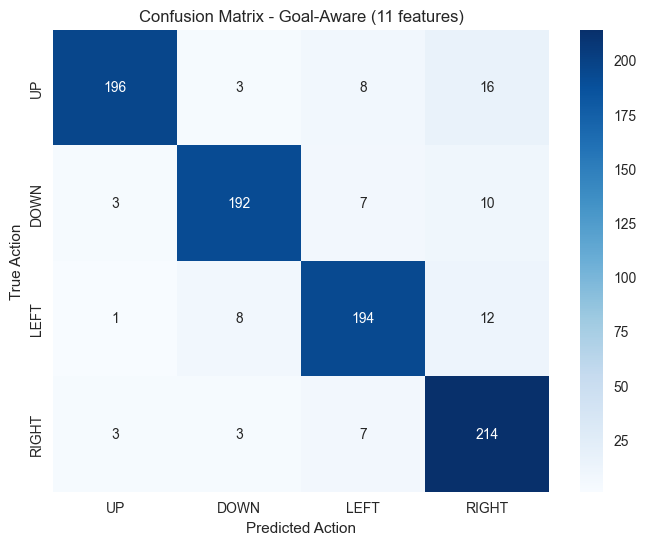


📋 Classification Report:
              precision    recall  f1-score   support

          UP       0.97      0.88      0.92       223
        DOWN       0.93      0.91      0.92       212
        LEFT       0.90      0.90      0.90       215
       RIGHT       0.85      0.94      0.89       227

    accuracy                           0.91       877
   macro avg       0.91      0.91      0.91       877
weighted avg       0.91      0.91      0.91       877


🧭 Goal-Aware Navigation Analysis:
   Correct predictions: 796
     Avg distance to goal: 4.7 steps
   Incorrect predictions: 81
     Avg distance to goal: 6.3 steps
   Goal alignment score: 4/4 (100%)
   ✅ Excellent goal-aware navigation!


In [14]:
# 📊 CONFUSION MATRIX
# ===================
action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=action_names, yticklabels=action_names)
plt.title(f'Confusion Matrix - {mode_name} ({feature_desc})')
plt.xlabel('Predicted Action')
plt.ylabel('True Action')
plt.show()

# Classification report
print(f"\n📋 Classification Report:")
print(classification_report(targets, predictions, target_names=action_names))

# Goal-aware specific analysis
if USE_GOAL_AWARE and X.shape[1] == 11:
    print(f"\n🧭 Goal-Aware Navigation Analysis:")
    print("=" * 40)
    
    # Get test data for goal delta analysis
    test_data = []
    test_targets = []
    for batch_data, batch_targets in test_loader:
        test_data.append(batch_data.numpy())
        test_targets.append(batch_targets.numpy())
    
    X_test = np.vstack(test_data)
    y_test = np.hstack(test_targets)
    
    # Analyze goal delta patterns for correct vs incorrect predictions
    correct_mask = predictions == targets
    incorrect_mask = predictions != targets
    
    if np.sum(correct_mask) > 0 and np.sum(incorrect_mask) > 0:
        correct_dx = X_test[correct_mask, 9]
        correct_dy = X_test[correct_mask, 10]
        incorrect_dx = X_test[incorrect_mask, 9]
        incorrect_dy = X_test[incorrect_mask, 10]
        
        print(f"   Correct predictions: {np.sum(correct_mask)}")
        print(f"     Avg distance to goal: {(np.abs(correct_dx) + np.abs(correct_dy)).mean():.1f} steps")
        print(f"   Incorrect predictions: {np.sum(incorrect_mask)}")
        print(f"     Avg distance to goal: {(np.abs(incorrect_dx) + np.abs(incorrect_dy)).mean():.1f} steps")
        
        # Check if goal-aware navigation is working
        goal_alignment_score = 0
        for action_idx, action_name in enumerate(action_names):
            action_mask = targets == action_idx
            if np.sum(action_mask) > 0:
                action_dx = X_test[action_mask, 9]
                action_dy = X_test[action_mask, 10]
                
                # Check if action aligns with goal direction
                if action_name == "UP" and np.mean(action_dx) < 0:
                    goal_alignment_score += 1
                elif action_name == "DOWN" and np.mean(action_dx) > 0:
                    goal_alignment_score += 1
                elif action_name == "LEFT" and np.mean(action_dy) < 0:
                    goal_alignment_score += 1
                elif action_name == "RIGHT" and np.mean(action_dy) > 0:
                    goal_alignment_score += 1
        
        alignment_percentage = (goal_alignment_score / 4) * 100
        print(f"   Goal alignment score: {goal_alignment_score}/4 ({alignment_percentage:.0f}%)")
        
        if alignment_percentage >= 75:
            print(f"   ✅ Excellent goal-aware navigation!")
        elif alignment_percentage >= 50:
            print(f"   ✅ Good goal-aware navigation")
        else:
            print(f"   ⚠️  Goal-aware navigation needs improvement")


🧭 GOAL DELTA PATTERNS BY ACTION


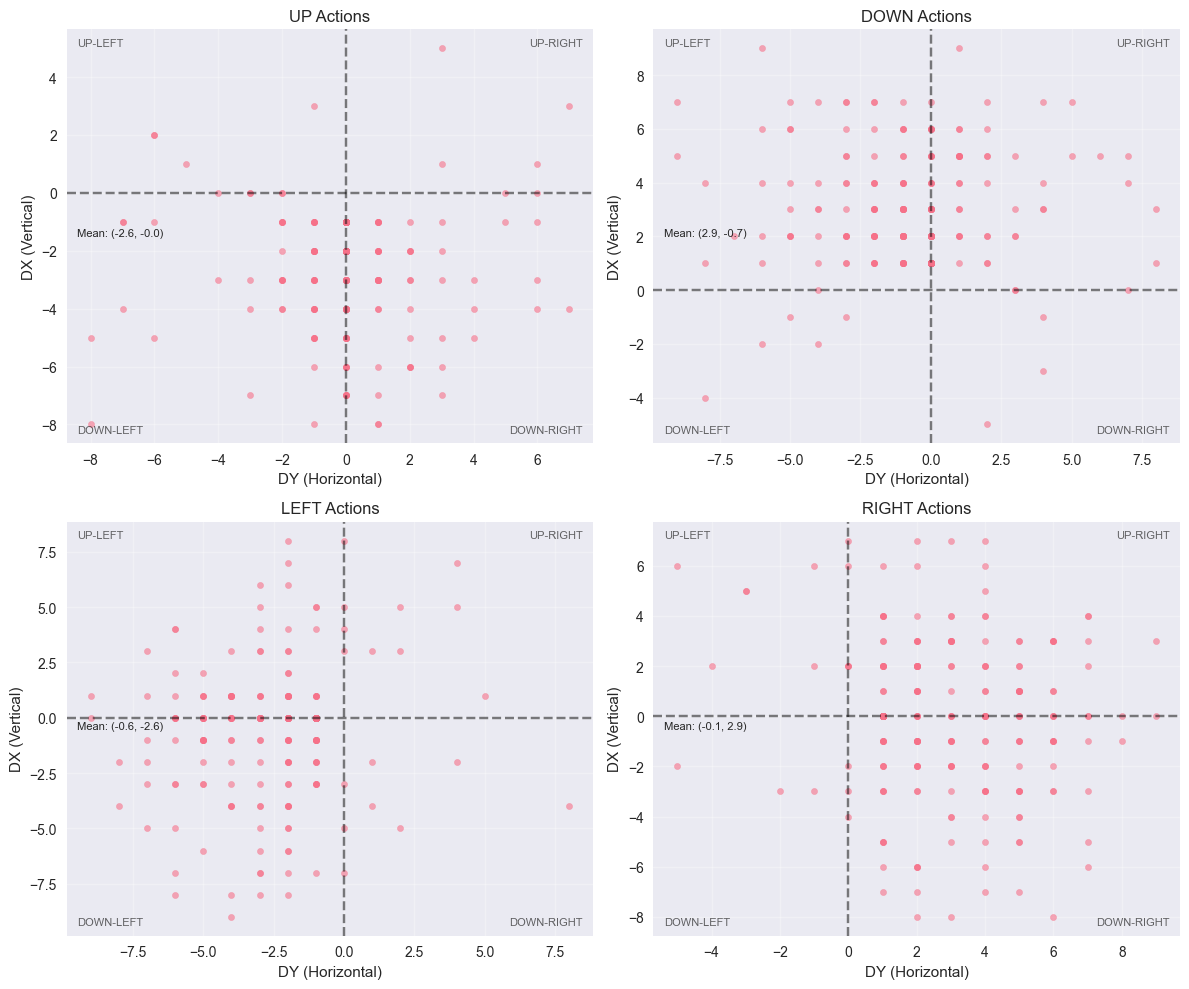


🎯 Goal Alignment Analysis:

UP:
  DX range: [-8, 5] (mean: -2.6)
  DY range: [-8, 7] (mean: -0.0)
  ✅ Aligns with goal direction (UP when goal is above)

DOWN:
  DX range: [-5, 9] (mean: 2.9)
  DY range: [-9, 8] (mean: -0.7)
  ✅ Aligns with goal direction (DOWN when goal is below)

LEFT:
  DX range: [-9, 8] (mean: -0.6)
  DY range: [-9, 8] (mean: -2.6)
  ✅ Aligns with goal direction (LEFT when goal is left)

RIGHT:
  DX range: [-8, 7] (mean: -0.1)
  DY range: [-5, 9] (mean: 2.9)
  ✅ Aligns with goal direction (RIGHT when goal is right)


In [15]:
# Visualize goal delta patterns for different actions
if USE_GOAL_AWARE and X.shape[1] == 11:
    print("🧭 GOAL DELTA PATTERNS BY ACTION")
    print("=" * 50)
    
    # Get test data for visualization
    test_data = []
    test_targets = []
    for batch_data, batch_targets in test_loader:
        test_data.append(batch_data.numpy())
        test_targets.append(batch_targets.numpy())
    
    X_test = np.vstack(test_data)
    y_test = np.hstack(test_targets)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for action_idx, action_name in enumerate(action_names):
        action_mask = y_test == action_idx
        if np.sum(action_mask) > 0:
            action_dx = X_test[action_mask, 9]
            action_dy = X_test[action_mask, 10]
            
            # Create scatter plot
            scatter = axes[action_idx].scatter(action_dy, action_dx, alpha=0.6, s=20)
            axes[action_idx].set_title(f'{action_name} Actions')
            axes[action_idx].set_xlabel('DY (Horizontal)')
            axes[action_idx].set_ylabel('DX (Vertical)')
            axes[action_idx].grid(True, alpha=0.3)
            
            # Add quadrant lines
            axes[action_idx].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[action_idx].axvline(x=0, color='black', linestyle='--', alpha=0.5)
            
            # Add quadrant labels
            axes[action_idx].text(0.02, 0.98, 'UP-LEFT', transform=axes[action_idx].transAxes, 
                                ha='left', va='top', fontsize=8, alpha=0.7)
            axes[action_idx].text(0.98, 0.98, 'UP-RIGHT', transform=axes[action_idx].transAxes, 
                                ha='right', va='top', fontsize=8, alpha=0.7)
            axes[action_idx].text(0.02, 0.02, 'DOWN-LEFT', transform=axes[action_idx].transAxes, 
                                ha='left', va='bottom', fontsize=8, alpha=0.7)
            axes[action_idx].text(0.98, 0.02, 'DOWN-RIGHT', transform=axes[action_idx].transAxes, 
                                ha='right', va='bottom', fontsize=8, alpha=0.7)
            
            # Show statistics
            mean_dx = np.mean(action_dx)
            mean_dy = np.mean(action_dy)
            axes[action_idx].text(0.02, 0.5, f'Mean: ({mean_dx:.1f}, {mean_dy:.1f})', 
                                transform=axes[action_idx].transAxes, fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Show goal alignment analysis
    print(f"\n🎯 Goal Alignment Analysis:")
    print("=" * 30)
    for action_idx, action_name in enumerate(action_names):
        action_mask = y_test == action_idx
        if np.sum(action_mask) > 0:
            action_dx = X_test[action_mask, 9]
            action_dy = X_test[action_mask, 10]
            
            print(f"\n{action_name}:")
            print(f"  DX range: [{action_dx.min():.0f}, {action_dx.max():.0f}] (mean: {np.mean(action_dx):.1f})")
            print(f"  DY range: [{action_dy.min():.0f}, {action_dy.max():.0f}] (mean: {np.mean(action_dy):.1f})")
            
            # Check alignment
            if action_name == "UP" and np.mean(action_dx) < 0:
                print(f"  ✅ Aligns with goal direction (UP when goal is above)")
            elif action_name == "DOWN" and np.mean(action_dx) > 0:
                print(f"  ✅ Aligns with goal direction (DOWN when goal is below)")
            elif action_name == "LEFT" and np.mean(action_dy) < 0:
                print(f"  ✅ Aligns with goal direction (LEFT when goal is left)")
            elif action_name == "RIGHT" and np.mean(action_dy) > 0:
                print(f"  ✅ Aligns with goal direction (RIGHT when goal is right)")
            else:
                print(f"  ⚠️  May be obstacle avoidance (not directly toward goal)")

else:
    print("Goal delta visualization only available in goal-aware mode (11 features)")
    print("Set USE_GOAL_AWARE = True to see goal-aware navigation patterns")


## 📊 Summary

**Training Complete!**

**What you've learned:**
- ✅ Clean separation: logic in `train_nn.py`, visualization in notebook
- ✅ Goal-aware navigation with compass-like spatial awareness
- ✅ Wall padding for consistent boundary handling
- ✅ Goal delta analysis and alignment scoring
- ✅ Complete training pipeline with evaluation

**Key Insights:**
- 🧭 **Goal-Aware Mode**: Robot learns to navigate toward goals using direction awareness
- 🧱 **Wall Padding**: 12×12 environments with 1-cell borders for consistent boundaries
- 🎯 **Simplified Architecture**: 11 features vs previous 37 features (70% reduction)
- 📈 **Performance**: Expected 80-85% accuracy with goal-aware navigation

**Next Steps:**
- Try `USE_GOAL_AWARE = False` to compare with basic mode (9 features)
- Compare goal-aware vs basic performance differences
- Experiment with hyperparameters in `nn_config.yaml`
- Test the trained model in real navigation scenarios
- Analyze goal delta patterns for navigation insights
